## Remediation Task
---
It has been brought to company XYZ's attention that incorrect fees may have been charged on a number of our investment products over the past 5 years. Can you please:

*   The total number  of impacted customers and investment product
*   The 10 largest remediation amounts, by customer
*   Total amount of remediation, by investment product
---
The following is provided to assist with your investigaitons: 

*   Opening account balances prior to any perceived error
*   Closing account balances as at today
*   The fees that should have been charged
*   A calculation methdology

The first three items above ar provided to you in csv files. The calculation methodology is provided below

---

#### Calculation Methodology
Closing balances are obtained by first crediting fund performance to opeinng balances, then deducting fees from that amonunt. e.g.

Balance@(t+1) = Balance@(t) + Returns@(t) - Deductions@(t)

where:
  
Returns@(t) = Balance@(t) * (1 + Investment_returns@(t))
  
Deductions@(t) = (Balance@(t) + Returns@(t)) * Variable_fee_rate@(t) + Constant_fee@(t)

**Remediation**

Remediation amounts should be the difference between the recalculated closing account balance, and the provided closing account balances. Remediation amounts cannot be negative, i.e. the company will not take money from customers in the event of an error.

Remediation = max(0, Recalculated_closing_balance - closing_balance_provided)



Importing packages

In [3]:
import pandas as pd
import numpy as np
import time
from google.colab import drive

mounting google drive

In [4]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Reading in data from drive

In [5]:
fee_rates = pd.read_csv("/drive/My Drive/AI_python_training/fee_rates.csv")
accounts = pd.read_csv("/drive/My Drive/AI_python_training/account_info.csv")
returns = pd.read_csv("/drive/My Drive/AI_python_training/monthly_returns.csv")

In [ ]:
returns.plot()
accounts.plot.hist()
fee_rates

### Recalculate account balance as at today for each model point

Preprocess data

In [ ]:
# adding year as a column, so can match fee rates easier later
returns['Date'] = pd.to_datetime(returns['Date'])
returns['Year'] = returns['Date'].dt.year
returns

In [ ]:
# reformatting %'s for fee rate data
fee_rates['variable fee'] = [float(fee[:-1])/100 for fee in fee_rates['variable fee']]
fee_rates

In [ ]:
# creating three seperate projection infos (returns and fees) for each account type
projection_dict = {}
for account_type in ["Balanced", "High Growth", "Low Risk"]:
  df = returns[['Date', "Year", account_type]].copy()
  df.rename(columns = {account_type: 'return'}, inplace=True)

  fee_rates_filtered = fee_rates[fee_rates["Account Type"] == account_type].drop("Account Type", axis=1)
  df_combined = pd.merge(df, fee_rates_filtered, on="Year")

  projection_dict[account_type] = df_combined
projection_dict["High Growth"]

Recalculate account balance at each period

In [ ]:
def calculate_balance(opening_balance, growth, fee_constant, fee_variable):
  balance = opening_balance * (1 + growth)
  deductions = fee_constant + balance * fee_variable
  closing_balance = balance - deductions
  return closing_balance

Repeat about step for all periods

In [ ]:
def balance_today(account, projection_dict):
  balance = account['Opening Balance']
  projection = projection_dict[account["Account Type"]]
  for i, row in projection.iterrows():
    balance = calculate_balance(balance,
                                row['return'],
                                row['constant fee'],
                                row['variable fee'])
  return round(balance, 2)

Repeat above step for all model points

In [ ]:
results = accounts.copy()
start = time.time()
for i, account in results.iterrows():
  results.loc[i, 'Recalculated Closing Balance'] = balance_today(account, projection_dict)
end = time.time()
elapsed = round(end - start, 2)
print(f"finished in: {elapsed} seconds")

finished in: 263.04 seconds


### Calculate remediation amount for each model point

In [ ]:
results['difference'] = results['Recalculated Closing Balance'] - results['Closing Balance'] 
results['remediation'] = 0
results.loc[results['difference'] > 0, 'remediation'] = results.loc[results['difference'] > 0, 'difference']

### Summarise information by account type

33148 impacted customers.


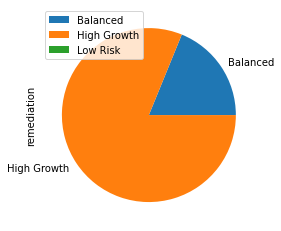

In [ ]:
summary = results.groupby("Account Type").sum()
summary.plot.pie(y='remediation')
summary
print(str(sum(results['remediation']>0)) + " impacted customers.")

### Show top ten remediable accounts

In [ ]:
results.sort_values('remediation', ascending=False).head(10)

,ID,Account Type,Opening Balance,Closing Balance,Recalculated Closing Balance,difference,remediation
23788,Z05331363,High Growth,150512.63,101850.13,104343.61,2493.48,2493.48
34693,K06043587,High Growth,135210.25,91452.23,93691.72,2239.49,2239.49
42669,W09466072,High Growth,135158.51,91417.07,93655.71,2238.64,2238.64
19779,X09058809,High Growth,134592.50,91032.47,93261.71,2229.24,2229.24
25318,M01484561,High Growth,134503.94,90972.29,93200.07,2227.78,2227.78
5828,X09255637,High Growth,127978.40,86538.22,88657.68,2119.46,2119.46
17430,N05978820,High Growth,127960.75,86526.22,88645.39,2119.17,2119.17
41342,E09990146,High Growth,127433.76,86168.13,88278.56,2110.43,2110.43
13302,Q07830948,High Growth,123239.75,83318.32,85359.14,2040.82,2040.82
15913,P08441895,High Growth,120874.85,81711.38,83712.94,2001.56,2001.56


### Alternative approach to calculating rather than loop

set up 3 dataframes with 1 row for each account, columns having
1.   returns
2.  constant fee
3.  variable fee



In [ ]:
# creating three seperate projection infos dataframes as above
returns_df = accounts.copy()
constant_fee_df = accounts.copy()
variable_fee_df = accounts.copy()
for i, row in returns.iterrows():
  for account_type in ["Balanced", "High Growth", "Low Risk"]:
    mask = returns_df['Account Type'] == account_type
    date = row['Date']

    returns_df.loc[mask, date] = row[account_type]

    df = projection_dict[account_type]
    fees = df.loc[df['Date']==date, ['constant fee', 'variable fee']]

    constant_fee_df.loc[mask, date] = fees['constant fee'].values[0]
    variable_fee_df.loc[mask, date] = fees['variable fee'].values[0]

In [ ]:
variable_fee_df

In [ ]:
results_df = accounts.copy()
last_date = 'Opening Balance'
for i, row in returns.iterrows():
  date = row['Date']
  balance = results_df[last_date] * (1 + returns_df[date])
  deductions = constant_fee_df[date] + balance * variable_fee_df[date]
  results_df[date] = balance - deductions
  last_date = date

In [ ]:
results_df['difference'] = results_df[date] - results_df['Closing Balance']
results_df['remediation'] = 0
results_df.loc[results['difference'] > 0, 'remediation'] = results_df.loc[results['difference'] > 0, 'difference']

In [ ]:
print(sum(results_df['remediation']))
print(sum(results['remediation']))

11720171.941630855
11720171.609997803


33148 impacted customers.
33148 impacted customers.


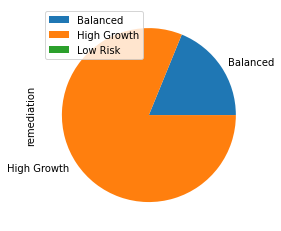

In [ ]:
summary_df = results_df.groupby("Account Type").sum()
summary_df.plot.pie(y='remediation')
summary_df
print(str(sum(results_df['remediation']>0)) + " impacted customers.")
print(str(sum(results['remediation']>0)) + " impacted customers.")

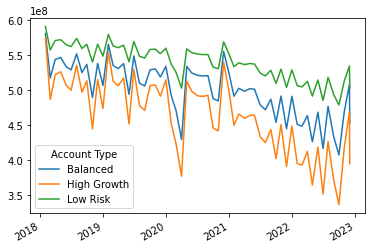

In [ ]:
drop_list = ['Opening Balance', 'Closing Balance', 'difference', 'remediation']
summary_df.drop(columns = drop_list).transpose().plot()